In [9]:
def S(V, B_s):
    return 10 - 7*V/(B_s+V)
    

def NoTreatmentSys(t, y, params):
    mu_T, mu_T_i, k_s, k_nu, p, p_i, C, C_i, G_s, B, B_s, N = params
    T, T_s, V_s = y
    return [S(V_s, B_s) - mu_T*T + T*p*V_s/(C+V_s) - k_s*V_s*T,
            k_s*V_s*T - mu_T_i*T_s - p_i*T_s*V_s/(C_i+V_s),
            N*p_i*T_s*V_s/(C_i+V_s) - k_nu*T*V_s + G_s*V_s/(B+V_s)]

In [24]:
# No treatment scenarios

scenario = 3

if scenario == 1:
    ymax = 20
    G_s = 80.0
    t_max = 14
    n_points = 1000
elif scenario == 2:
    ymax = 20
    G_s = 180.0
    t_max = 1225
    n_points = 3000
elif scenario == 3:
    ymax = 600
    G_s = 330.0
    t_max = 2100
    n_points = 6000

# Article values for parameters
# params = (0.01, # mu_T
#           0.5,  # mu_T_i
#           2.5e-4, # k_s
#           0.01, # k_nu
#           0.5, # p
#           0.5, # p_i
#           188.0, # C
#           188.0, # C_i
#           G_s, # G_s
#           8.0, # B
#           55.0, # B_s
#           10.0, # N
#          )

# Values designed to fit article plots
params_no_treatment = (0.01, # mu_T
                       0.5,  # mu_T_i
                       2.3233e-4, # k_s
                       0.00825, # k_nu
                       0.05, # p
                       0.05, # p_i
                       188.0, # C
                       188.0, # C_i
                       G_s, # G_s
                       12, # B
                       55.0, # B_s
                       10.0, # N
                      )

Solver = ode_solver()
Solver.algorithm = "rk8pd"
Solver.function = NoTreatmentSys
Solver.ode_solve(y_0 = [1000.0, 0.0, 10.0], t_span=[0.0, t_max], params=params_no_treatment, num_points=n_points)

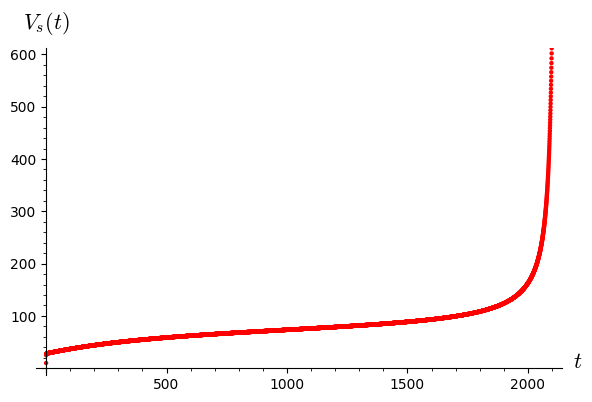

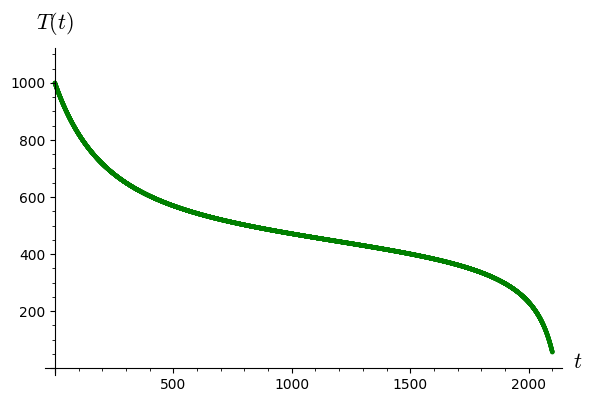

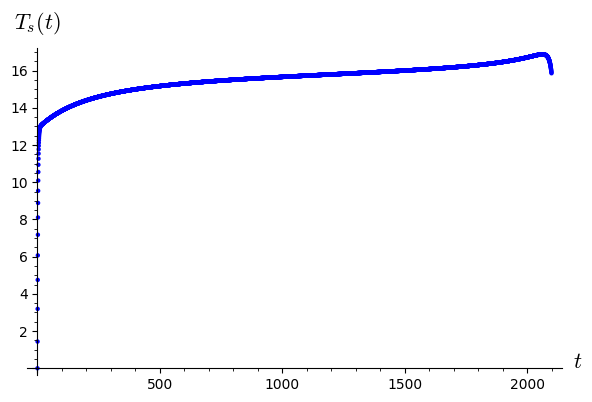

In [25]:
Solver.plot_solution(i=2, color="red", axes_labels=["$t$", "$V_s(t)$"], ymin=0, ymax=ymax)
Solver.plot_solution(i=0, color="green", axes_labels=["$t$", "$T(t)$"], ymin=0, ymax=1100)
Solver.plot_solution(i=1, color="blue", axes_labels=["$t$", "$T_s(t)$"])

In [59]:
def q_fn(t, q, t_r):
    return 1 if t < t_r else q

def S_0(V, B_s, S_t_0):
    return min(S(V, B_s), S_t_0)
    
def WithTreatmentSys(t, y, params):
    mu_T, mu_T_i, k_s, k_nu, p, p_i, C, C_i, G_s, \
    B, B_s, N, k_r, G_r, q, mu, eta, rho, t_r, t_0, S_T_0 = params
    T, T_s, T_r, V_s, V_r = y
    V = V_s + V_r
    dT = S_0(V, B_s, S_t_0) - mu_T*T + p*T*V/(C+V) - (mu*k_s*V_s + k_r*V_r)*T
    dT_s = mu*k_s*V_s*T - mu_T_i*T_s - p_i*T_s*V/(C_i+V)
    dT_r = k_r*V_r*T - mu_T_i*T_r - p_i*T_r*V/(C_i+V)
    dV_s = rho*q_fn(t, q, t_r)*N*p_i*T_s*V/(C_i+V) - k_nu*T*V_s + eta*G_s*V_s/(B+V)
    dV_r = q_fn(t, q, t_r)*N*p_i*T_r*V/(C_i+V) + (1-q_fn(t, q, t_r))*N*p_i*T_s*V/(C_i+V) - k_nu*T*V_r + G_r*V_r/(B+V)
    return [dT, dT_s, dT_r, dV_s, dV_r]
    
def find_T_pos(solution, T):
    for i, (t, state) in enumerate(solution):
        if state[0] < T:
            return i

In [80]:
T_trigger = 300 # Treatment starts when T hits T_trigger
G_s = 330
t_max_no_treatment = 7*300
t_max_from_treatment = 7*120
n_points = 3000



Solver_no_treatment = ode_solver()
Solver_no_treatment.algorithm = "rk8pd"
Solver_no_treatment.function = NoTreatmentSys
Solver_no_treatment.ode_solve(y_0 = [1000.0, 0.0, 10.0], t_span=[0.0, t_max_no_treatment], params=params_no_treatment, num_points=n_points)

final_state = find_T_pos(Solver_no_treatment.solution, T_trigger)

init_T = Solver_no_treatment.solution[final_state][1][0]
init_T_s = Solver_no_treatment.solution[final_state][1][1]
init_V_s = Solver_no_treatment.solution[final_state][1][2]

t_0 = Solver_no_treatment.solution[final_state][0]
t_r = 30*7

S_t_0 = S(init_V_s, 55.0) # B_s = 55.0

# # Article values for new parameters
# new_params = (2.5e-4, # k_r
#               0.9995 * G_s, # G_r
#               0.999, # q
#               0.9, # mu
#               0.15, # eta
#               0.05, # rho
#               t_r,
#               t_0,
#               S_t_0,
#              )


2.3233e-4
# Values for new parameters desinged to fit article plots
new_params = (2.285e-4, # k_r
              0.9995 * G_s, # G_r
              0.999, # q
              0.9, # mu
              0.15, # eta
              0.05, # rho
              t_r,
              t_0,
              S_t_0,
             )

params_with_treatment = params_no_treatment + new_params

Solver_with_treatment = ode_solver()
Solver_with_treatment.algorithm = "rk8pd"
Solver_with_treatment.function = WithTreatmentSys
Solver_with_treatment.ode_solve(y_0 = [init_T, init_T_s, 0.0, init_V_s, 0.0], t_span=[0, t_max_from_treatment], params=params_with_treatment, num_points=n_points)

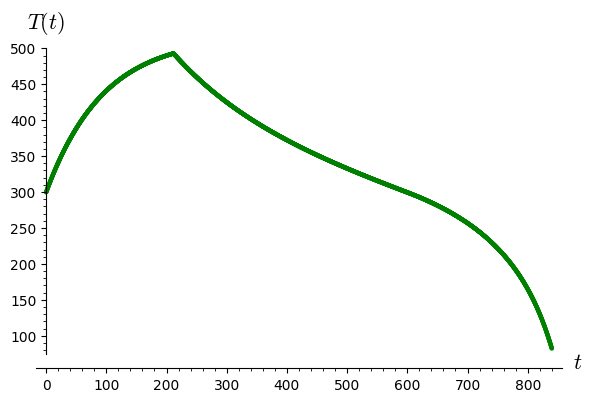

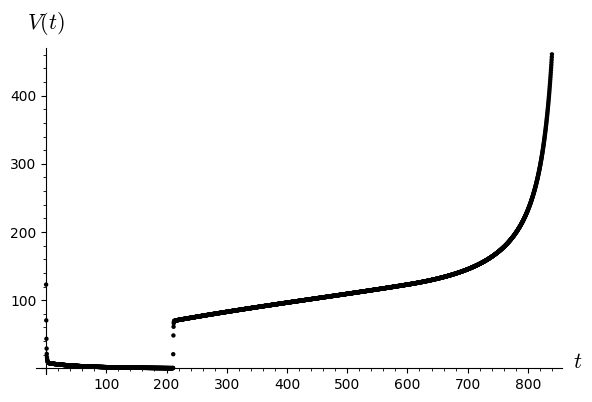

In [81]:
Solver_with_treatment.plot_solution(i=0, color="green", axes_labels=["$t$", "$T(t)$"])#, ymin=0, ymax=ymax)
# Solver_with_treatment.plot_solution(i=3, color="red", axes_labels=["$t$", "$V_s(t)$"])#, ymin=0, ymax=ymax)
# Solver_with_treatment.plot_solution(i=4, color="black", axes_labels=["$t$", "$V_r(t)$"])#, ymin=0, ymax=ymax)
# Solver_with_treatment.plot_solution(i=1, color="purple", axes_labels=["$t$", "$T_s(t)$"])#, ymin=0, ymax=ymax)
# Solver_with_treatment.plot_solution(i=2, color="orange", axes_labels=["$t$", "$T_r(t)$"])#, ymin=0, ymax=ymax)
V = list_plot([(state[0], state[1][3] + state[1][4]) for state in Solver_with_treatment.solution], color = "black", axes_labels=["$t$", "$V(t)$"])
V.legend()
show(V)

In [55]:
Solver_with_treatment.solution

[(0,
  [299.75661309137155,
   16.449269010054945,
   122.79146630755695,
   0.000000000000000,
   0.000000000000000]),
 (0.28,
  [300.36277386754864, 14.287243303721509, 106.74977247116962, 0.0, 0.0]),
 (0.56, [300.96723976748655, 12.407668450776615, 92.80379382476004, 0.0, 0.0]),
 (0.8400000000000001,
  [301.5700155302009, 10.773644573320473, 80.67974243780797, 0.0, 0.0]),
 (1.12, [302.17110588145687, 9.353092458615686, 70.13959851816288, 0.0, 0.0]),
 (1.4000000000000001,
  [302.77051553380585, 8.118123778883891, 60.97643759933078, 0.0, 0.0]),
 (1.6800000000000002,
  [303.36824918662256, 7.044493586699465, 53.0103681922596, 0.0, 0.0]),
 (1.9600000000000002,
  [303.96431152614196, 6.111124337351132, 46.08500014946379, 0.0, 0.0]),
 (2.24, [304.55870722549577, 5.299692093762157, 40.06437440829154, 0.0, 0.0]),
 (2.5200000000000005,
  [305.15144094474937, 4.594266790329952, 34.830293837949405, 0.0, 0.0]),
 (2.8000000000000007,
  [305.74251733093814, 3.9809994933324626, 30.28000278938159, 

In [50]:
WithTreatmentSys(0, [0, 0, 0, 0, 0], params_with_treatment)

[5.16545826408787,
 -0.0500000000000000,
 0.000000000000000,
 0.000000000000000,
 0.000000000000000]